In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from enum import Enum

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.axes import Axes
import matplotlib.transforms as mtransforms
import matplotlib.artist as martist

class Axes3DPatched(Axes3D):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def get_tightbbox(self, renderer=None, *, call_axes_locator=True,
                      bbox_extra_artists=None, for_layout_only=False):
        ret = Axes.get_tightbbox(self, renderer,
                                 call_axes_locator=call_axes_locator,
                                 bbox_extra_artists=bbox_extra_artists,
                                 for_layout_only=for_layout_only)
        batch = [ret]
        if self._axis3don:
            for axis in self._axis_map.values():
                if axis.get_visible():
                    if for_layout_only:
                        axis_bb = martist._get_tightbbox_for_layout_only(axis, renderer)
                    else:
                        axis_bb = axis.get_tightbbox(renderer)
                    if axis_bb:
                        batch.append(axis_bb)
        return mtransforms.Bbox.union(batch)


class ImplicationAlgorithm(Enum):
    LUKASIEWICZ = "lukasiewicz"
    MAMDANI = "mamdani"
    LARSEN = "larsen"
    GODEL = "godel"
    MAXMIN = "maxmin"


class FuzzySet:
    def __init__(self, data: dict):
        self.values = data.copy()

    def __getitem__(self, x):
        return self.values.get(x, 0)

    def __repr__(self):
        return f"""FuzzySet({{{', '.join(
            f'({m:.2f}; {x})' for x, m in sorted(self.values.items(), key=lambda x: x[0])
        )}}})"""

    def __invert__(self):
        return FuzzySet({x: 1 - m for x, m in self.values.items()})

    def __or__(self, other: "FuzzySet"):
        result = {}
        all_elements = set(self.values.keys()) | set(other.values.keys())
        for x in all_elements:
            m1 = self.values.get(x, 0)
            m2 = other.values.get(x, 0)
            result[x] = max(m1, m2)
        return FuzzySet(result)

    def __and__(self, other: "FuzzySet"):
        result = {}
        all_elements = set(self.values.keys()) | set(other.values.keys())
        for x in all_elements:
            m1 = self.values.get(x, 0)
            m2 = other.values.get(x, 0)
            result[x] = min(m1, m2)
        return FuzzySet(result)
    
    def __truediv__(self, other: "FuzzySet"):
        return self & ~other
    
    def __xor__(self, other: "FuzzySet"):
        return (self / other) | (other / self)
    
    def implies(self, other: "FuzzySet", algorithm: ImplicationAlgorithm = ImplicationAlgorithm.LUKASIEWICZ):
        result = {}

        for x, a in self.values.items():
            for y, b in other.values.items():
                match algorithm:
                    case ImplicationAlgorithm.MAMDANI:
                        m = min(a, b)
                    case ImplicationAlgorithm.LUKASIEWICZ:
                        m = min(1, 1 - a + b)
                    case ImplicationAlgorithm.LARSEN:
                        m = a * b
                    case ImplicationAlgorithm.GODEL:
                        m = 1 if a <= b else b
                    case ImplicationAlgorithm.MAXMIN:
                        m = max(min(a, b), 1 - a)
                    case _:
                        raise ValueError("Unknown implication type")

                result[(x, y)] = m

        return FuzzyRelation(result)

    def defuzzify(self):
        num = sum(x * m for x, m in self.values.items())
        den = sum(m for m in self.values.values())
        return num / den if den != 0 else None
    
    def plot(self, title="Нечеткое множество", color="blue"):
        xs = sorted(self.values.keys())
        ys = [self.values[x] for x in xs]

        plt.figure(figsize=(6, 3))
        plt.plot(xs, ys, color=color, linewidth=2)
        plt.fill_between(xs, ys, color=color, alpha=0.2)
        plt.title(title)
        plt.xlabel("Элемент (x)")
        plt.ylabel("Степень принадлежности μ(x)")
        plt.ylim(-0.05, 1.05)
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()

    @staticmethod
    def plot_many(sets: dict, title="Нечеткие множества"):
        plt.figure(figsize=(7, 4))
        for name, fs in sets.items():
            xs = sorted(fs.values.keys())
            ys = [fs.values[x] for x in xs]
            plt.plot(xs, ys, linewidth=2, label=name)
            plt.fill_between(xs, ys, alpha=0.15)

        plt.title(title)
        plt.xlabel("Элемент (x)")
        plt.ylabel("Степень принадлежности μ(x)")
        plt.ylim(-0.05, 1.05)
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.legend()
        plt.show()


class FuzzyRelation:
    def __init__(self, data: dict):
        self.values = data.copy()

    def __getitem__(self, pair):
        return self.values.get(pair, 0)

    def __repr__(self):
        return f"""FuzzyRelation({{{', '.join(
            f'({m:.2f}; {x}, {y})' for (x, y), m in sorted(self.values.items(), key=lambda x: x[0])
        )}}})"""
    
    def on(self, x):
        return FuzzySet({y: m for (x1, y), m in self.values.items() if x1 == x})
    
    def plot(self, title="Нечёткое отношение", cmap="viridis"):
        xs = sorted({x for (x, _) in self.values.keys()})
        ys = sorted({y for (_, y) in self.values.keys()})

        X, Y = np.meshgrid(xs, ys, indexing="xy")
        Z = np.zeros_like(X, dtype=float)

        for i, y in enumerate(ys):
            for j, x in enumerate(xs):
                Z[i, j] = self.values.get((x, y), 0.0)

        fig = plt.figure(figsize=(14, 4))
        ax1: Axes3D = fig.add_subplot(121, axes_class=Axes3DPatched)

        surf = ax1.plot_surface(X, Y, Z,
                            cmap=cmap,
                            linewidth=0,
                            antialiased=True,
                            alpha=0.9)

        ax1.set_xlabel("Элемент (x)")
        ax1.set_ylabel("Элемент (y)")
        ax1.set_zlabel("Степень принадлежности μ(x, y)")
        ax1.set_zlim(-0.05, 1.05)
        ax1.view_init(elev=30, azim=225)

        ax2 = fig.add_subplot(122)
        im = ax2.imshow(Z, origin='lower',
                        extent=(min(xs), max(xs), min(ys), max(ys)),
                        aspect='auto', cmap=cmap, vmin=0, vmax=1)
        
        ax2.set_xlabel("Элемент (x)")
        ax2.set_ylabel("Элемент (y)")
        fig.colorbar(im, shrink=0.6, pad=0.1)

        plt.suptitle(title)
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()
    

def gaussian_fuzzy_set(a: float, b: float, step: float = 0.1, 
                       sigma: float = math.nan, center: float = math.nan) -> FuzzySet:
    center = center if not math.isnan(center) else (a + b) / 2
    sigma = sigma if not math.isnan(sigma) else (b - a) / 3
    data = {}

    x = a
    while x <= b:
        mu = math.exp(-((x - center) ** 2) / (sigma ** 2))
        data[round(x, 3)] = mu
        x += step

    return FuzzySet(data)

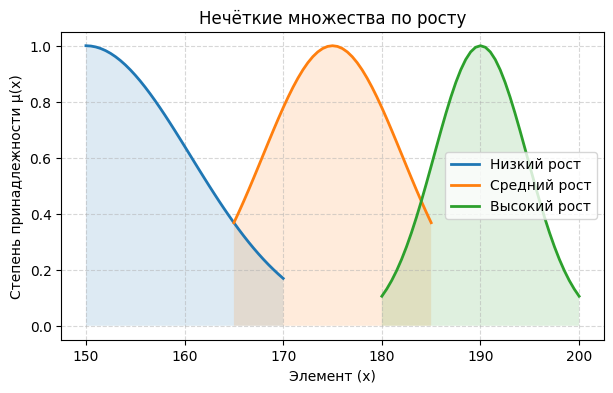

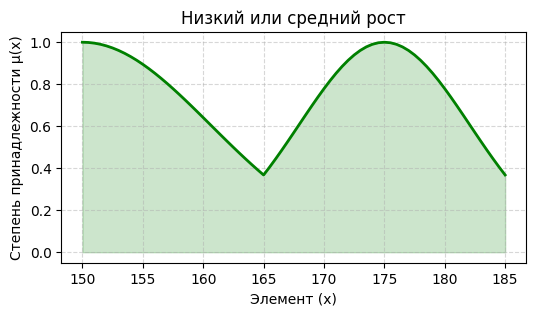

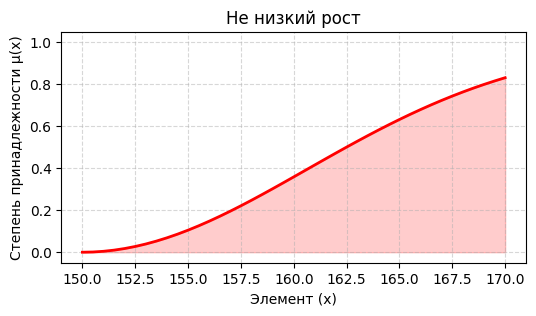

In [2]:
low = gaussian_fuzzy_set(150, 170, step=0.5, center=150, sigma=15)
medium = gaussian_fuzzy_set(165, 185, step=0.5, sigma=10)
high = gaussian_fuzzy_set(180, 200, step=0.5)

FuzzySet.plot_many({
    "Низкий рост": low,
    "Средний рост": medium,
    "Высокий рост": high
}, title="Нечёткие множества по росту")

low_or_medium = low | medium

low_or_medium.plot(title="Низкий или средний рост", color="green")

not_low = ~low

not_low.plot(title="Не низкий рост", color="red")

In [3]:
F = FuzzySet({75: 0.2, 90: 0.5, 120: 0.7, 150: 0.9, 200: 1})

G = FuzzySet({75: 0.9, 90: 0.6, 120: 0.4, 150: 0.3, 200: 0.1})

display(F / G)

display(F ^ G)

FuzzySet({(0.10; 75), (0.40; 90), (0.60; 120), (0.70; 150), (0.90; 200)})

FuzzySet({(0.80; 75), (0.50; 90), (0.60; 120), (0.70; 150), (0.90; 200)})

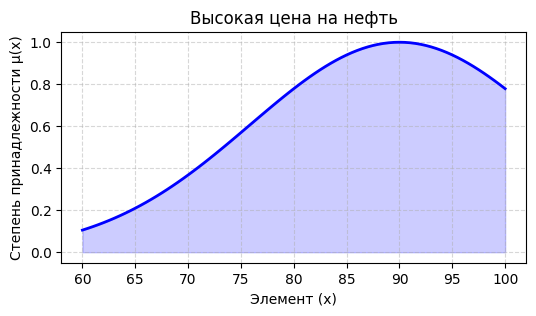

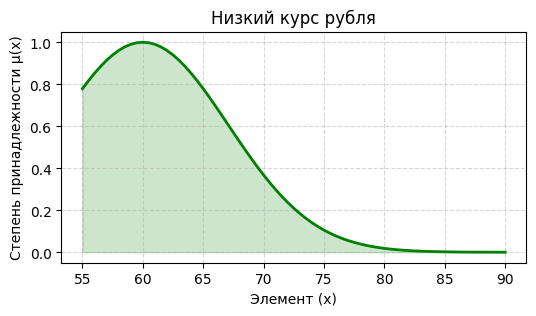

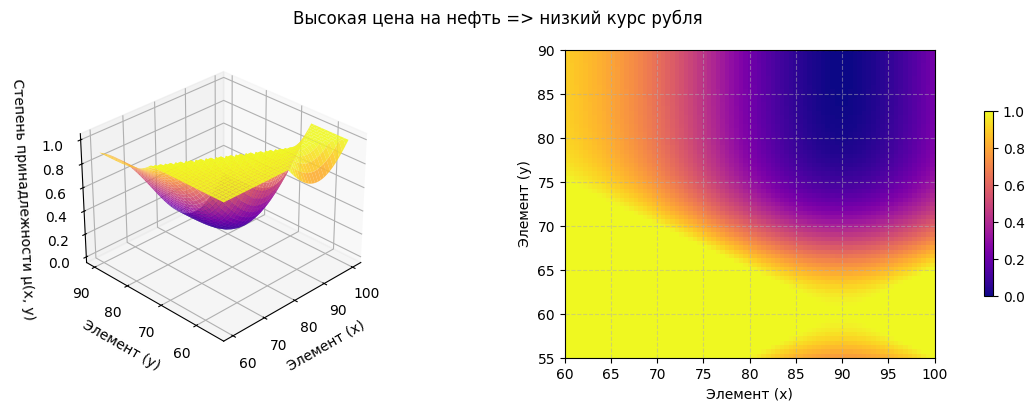

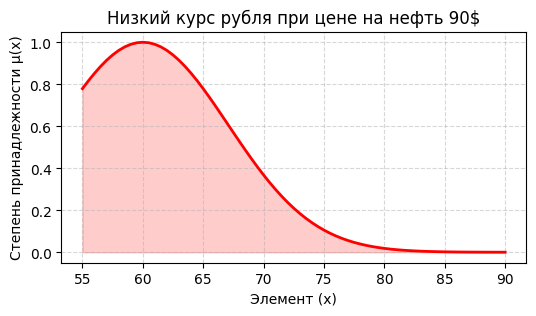

In [4]:
high_oil = gaussian_fuzzy_set(60, 100, step=0.5, center=90, sigma=20)

low_usd = gaussian_fuzzy_set(55, 90, step=0.5, center=60, sigma=10)

high_oil.plot(title="Высокая цена на нефть")
low_usd.plot(title="Низкий курс рубля", color="green")

R = high_oil.implies(low_usd, ImplicationAlgorithm.LUKASIEWICZ)

R.plot(title="Высокая цена на нефть => низкий курс рубля", cmap="plasma")

L = R.on(90)

L.plot(title="Низкий курс рубля при цене на нефть 90$", color="red")